In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:


file_path = 'Signals_2017.xlsx'
data = pd.read_excel(file_path, sheet_name='Signals_2017')  # Adjust nrows as needed
print(data.columns)



In [ ]:

# Display basic information about the DataFrame
print(data.info())


In [ ]:
# Check for missing values
print(data.isnull().sum())

In [ ]:
import matplotlib.pyplot as plt

# Plot Gen_RPM_Avg over time
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['Gen_RPM_Avg'], label='Gen_RPM_Avg')
plt.xlabel('Timestamp')
plt.ylabel('Gen_RPM_Avg')
plt.title('Generator RPM Average Over Time')
plt.legend()
plt.show()

# Plot Gen_Bear_Temp_Avg over time
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['Gen_Bear_Temp_Avg'], label='Gen_Bear_Temp_Avg', color='orange')
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Generator Bearing Temperature Average Over Time')
plt.legend()
plt.show()


In [5]:
#co-relation anlaysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Feature Engineering: Create rolling statistics and lag features

# Example: Create rolling mean and standard deviation for Gen_RPM_Avg
data['Gen_RPM_Avg_RollingMean'] = data['Gen_RPM_Avg'].rolling(window=6).mean()
data['Gen_RPM_Avg_RollingStd'] = data['Gen_RPM_Avg'].rolling(window=6).std()

# Example: Create lagged features for Gen_RPM_Avg
data['Gen_RPM_Avg_Lag1'] = data['Gen_RPM_Avg'].shift(1)
data['Gen_RPM_Avg_Lag2'] = data['Gen_RPM_Avg'].shift(2)

# Fill any remaining missing values
data.fillna(method='ffill', inplace=True)

# Display the first few rows of the DataFrame after feature engineering
print(data.head(15))


In [10]:
#identifying major parts

In [ ]:
# Group columns by major parts
parts = {
    'generator': [
        'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std',
        'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg',
        'Gen_SlipRing_Temp_Avg'
    ],
    'gearbox': [
        'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg'
    ],
    'nacelle': [
        'Nac_Temp_Avg', 'Nac_Direction_Avg'
    ],
    'rotor': [
        'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Rtr_RPM_Avg', 'Rtr_RPM_Std'
    ],
    'ambient': [
        'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min', 'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std',
        'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg'
    ]
}

# Display categorized parts
for part, sensors in parts.items():
    print(f"{part.capitalize()} Sensors: {sensors}")


In [32]:
#Implementing Step 2: Predict Maintenance Needs

In [ ]:
# Feature Engineering: Create rolling statistics and lag features for generator as an example
data['Gen_RPM_Avg_RollingMean'] = data['Gen_RPM_Avg'].rolling(window=6).mean()
data['Gen_RPM_Avg_RollingStd'] = data['Gen_RPM_Avg'].rolling(window=6).std()
data['Gen_Bear_Temp_Avg_RollingMean'] = data['Gen_Bear_Temp_Avg'].rolling(window=6).mean()
data['Gen_Bear_Temp_Avg_RollingStd'] = data['Gen_Bear_Temp_Avg'].rolling(window=6).std()

# Lag features
data['Gen_RPM_Avg_Lag1'] = data['Gen_RPM_Avg'].shift(1)
data['Gen_RPM_Avg_Lag2'] = data['Gen_RPM_Avg'].shift(2)
data['Gen_Bear_Temp_Avg_Lag1'] = data['Gen_Bear_Temp_Avg'].shift(1)
data['Gen_Bear_Temp_Avg_Lag2'] = data['Gen_Bear_Temp_Avg'].shift(2)

# Fill any remaining missing values
data.fillna(method='ffill', inplace=True)

# Display the first few rows of the DataFrame after feature engineering
print(data.head(15))


Let's use the column Prod_LatestAvg_TotActPwr (assuming it represents the total actual power generated) to identify outage points and create RUL labels based on this data. We'll find the lowest points in a specified window and assume those as outage points. Then, we'll create RUL labels by counting the number of time steps until the next outage.

Steps to Create RUL Labels Based on Outage Points
Identify Outage Points: Find the timestamps where the production power is the lowest within a rolling window.
Create RUL Labels: For each timestamp, calculate the RUL as the number of time steps until the next outage point.
Step 1: Identify Outage Points

We will define an outage point as the minimum value of Prod_LatestAvg_TotActPwr within a rolling window of a specified size (e.g., 100 time steps).

Step 2: Create RUL Labels

Using the identified outage points, we will create RUL labels.

Here's the code to achieve this:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Example feature and target for generator RUL prediction
features = [
    'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_RPM_Avg_RollingMean', 
    'Gen_RPM_Avg_RollingStd', 'Gen_RPM_Avg_Lag1', 'Gen_RPM_Avg_Lag2',
    'Gen_Bear_Temp_Avg', 'Gen_Bear_Temp_Avg_RollingMean', 
    'Gen_Bear_Temp_Avg_RollingStd', 'Gen_Bear_Temp_Avg_Lag1', 'Gen_Bear_Temp_Avg_Lag2'
]

# Placeholder target variable for demonstration purposes
# You should replace this with the actual RUL data
data['RUL_Generator'] = 1000 - (data.index % 1000)  # Dummy data for RUL

target = 'RUL_Generator'  # Assume RUL_Generator is a column indicating the remaining useful life of the generator

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


In [ ]:
import numpy as np
import pandas as pd

# Convert 'Timestamp' to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Define the window size for detecting outage points
window_size = 100

# Identify outage points
data['is_outage'] = data['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True)

# Fill NaN values in 'is_outage' with False
data['is_outage'].fillna(False, inplace=True)

# Create RUL labels
data['RUL'] = np.nan
last_outage_index = None
for i in range(len(data) - 1, -1, -1):
    if data['is_outage'].iloc[i]:
        last_outage_index = i
    if last_outage_index is not None:
        data['RUL'].iloc[i] = last_outage_index - i

# Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
data['RUL'].fillna(len(data), inplace=True)

# Display the first few rows to check the RUL label
print(data[['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']].head(20))

# Plot RUL over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['RUL'], label='RUL')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('Remaining Useful Life Based on Outage Points')
plt.legend()
plt.show()


Explanation
Rolling Window: We use a rolling window to identify outage points. The window size can be adjusted based on the desired sensitivity.
RUL Calculation: For each timestamp, the RUL is calculated as the number of time steps until the next outage point.
Handling NaN: NaN values are filled with a large number, assuming those points are far from an outage.
By running this code, we identify the outage points and create RUL labels for the turbine data. Once you confirm that the RUL labels are correct, we can proceed with training the predictive model using these labels.

In [ ]:
import numpy as np
import pandas as pd


# Convert 'Timestamp' to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Define the window size for detecting outage points
window_size = 100

# Identify outage points
data['is_outage'] = data['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True)

# Fill NaN values in 'is_outage' with False
data['is_outage'].fillna(False, inplace=True)

# Create RUL labels
data['RUL'] = np.nan
last_outage_index = None
for i in range(len(data) - 1, -1, -1):
    if data['is_outage'].iloc[i]:
        last_outage_index = i
    if last_outage_index is not None:
        data['RUL'].iloc[i] = last_outage_index - i

# Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
data['RUL'].fillna(len(data), inplace=True)

# Display the first few rows to check the RUL label
print(data[['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']].head(20))

# Plot RUL over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['RUL'], label='RUL')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('Remaining Useful Life Based on Outage Points')
plt.legend()
plt.show()


In [ ]:
# Corrected syntax for printing rows where is_outage is True
outage_data = data[data['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']]
print(outage_data)


In [ ]:
import numpy as np
import pandas as pd


# Convert 'Timestamp' to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Define the window size for detecting outage points
window_size = 100
power_threshold = 500  # Define an appropriate threshold based on domain knowledge

# Identify outage points
data['is_outage'] = (data['Prod_LatestAvg_TotActPwr'] < power_threshold) & \
                    (data['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True))

# Fill NaN values in 'is_outage' with False
data['is_outage'].fillna(False, inplace=True)

# Remove short outages by considering consecutive points
data['is_outage'] = data['is_outage'] & (data['is_outage'].rolling(window=3, min_periods=1).sum() >= 2)

# Create RUL labels
data['RUL'] = np.nan
last_outage_index = None
for i in range(len(data) - 1, -1, -1):
    if data['is_outage'].iloc[i]:
        last_outage_index = i
    if last_outage_index is not None:
        data['RUL'].iloc[i] = last_outage_index - i

# Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
data['RUL'].fillna(len(data), inplace=True)

# Print rows where is_outage is True
outage_data = data[data['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']]
print(outage_data)

# Plot RUL over time
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['RUL'], label='RUL')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('Remaining Useful Life Based on Outage Points')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd


# Convert 'Timestamp' to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Define the window size for detecting outage points
window_size = 50  # Adjusted window size
power_threshold = 1000  # Adjusted threshold based on distribution analysis

# Identify outage points
data['is_outage'] = (data['Prod_LatestAvg_TotActPwr'] < power_threshold) & \
                    (data['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True))

# Fill NaN values in 'is_outage' with False
data['is_outage'].fillna(False, inplace=True)

# Remove short outages by considering consecutive points
data['is_outage'] = data['is_outage'] & (data['is_outage'].rolling(window=3, min_periods=1).sum() >= 2)

# Create RUL labels
data['RUL'] = np.nan
last_outage_index = None
for i in range(len(data) - 1, -1, -1):
    if data['is_outage'].iloc[i]:
        last_outage_index = i
    if last_outage_index is not None:
        data['RUL'].iloc[i] = last_outage_index - i

# Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
data['RUL'].fillna(len(data), inplace=True)

# Print rows where is_outage is True
outage_data = data[data['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']]
print(outage_data)

# Plot RUL over time
plt.figure(figsize=(12, 6))
plt.plot(data['Timestamp'], data['RUL'], label='RUL')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('Remaining Useful Life Based on Outage Points')
plt.legend()
plt.show()


In [ ]:
########

In [ ]:
import pandas as pd

# Load the data from the Excel file
file_path_2016 = 'Signals_2016.xlsx'
file_path_2017 = 'Signals_2017.xlsx'

data_2016 = pd.read_excel(file_path_2016, sheet_name='Signals_2016')
data_2017 = pd.read_excel(file_path_2017, sheet_name='Signals_2017')

# Convert 'Timestamp' to datetime
data_2016['Timestamp'] = pd.to_datetime(data_2016['Timestamp'])
data_2017['Timestamp'] = pd.to_datetime(data_2017['Timestamp'])

# Display the first few rows to verify
print(data_2016.head())
print(data_2017.head())

In [ ]:
data_2016['Turbine_ID'].value_counts()

In [ ]:
data_2017['Turbine_ID'].value_counts()

In [41]:
# Extract unique turbine IDs
turbine_ids = data_2016['Turbine_ID'].unique()

# Create a dictionary to hold combined DataFrames for each turbine
combined_data = {}

# Combine data for each turbine
for turbine_id in turbine_ids:
    df_2016 = data_2016[data_2016['Turbine_ID'] == turbine_id].copy()
    df_2017 = data_2017[data_2017['Turbine_ID'] == turbine_id].copy()
    combined_df = pd.concat([df_2016, df_2017], ignore_index=True)
    combined_data[turbine_id] = combined_df

# Display the first few rows of the combined DataFrame for one turbine to verify
print(len(combined_data['T01']))

32769


In [ ]:
combined_data

In [ ]:
def identify_outages(data, window_size=50, power_threshold=1000):
    for turbine in data.keys():
        df = data[turbine]
        
        # Identify outage points
        df['is_outage'] = (df['Prod_LatestAvg_TotActPwr'] < power_threshold) & \
                          (df['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True))

        # Fill NaN values in 'is_outage' with False
        df['is_outage'].fillna(False, inplace=True)

        # Remove short outages by considering consecutive points
        df['is_outage'] = df['is_outage'] & (df['is_outage'].rolling(window=3, min_periods=1).sum() >= 2)
        
        # Create RUL labels
        df['RUL'] = np.nan
        last_outage_index = None
        for i in range(len(df) - 1, -1, -1):
            if df['is_outage'].iloc[i]:
                last_outage_index = i
            if last_outage_index is not None:
                df['RUL'].iloc[i] = last_outage_index - i

        # Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
        df['RUL'].fillna(len(df), inplace=True)
        
        data[turbine] = df  # Update the data dictionary with the new columns

# Identify outages and create RUL labels for the combined data
identify_outages(combined_data)


In [ ]:
import matplotlib.pyplot as plt

# Example turbine to compare
turbine_id = 'T01'

# Plot RUL for the combined data
plt.figure(figsize=(12, 6))
plt.plot(combined_data[turbine_id]['Timestamp'], combined_data[turbine_id]['RUL'], label='RUL')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title(f'RUL for Turbine {turbine_id}')
plt.legend()
plt.show()

# Print outage points for the turbine
print("Outages:")
print(combined_data[turbine_id][combined_data[turbine_id]['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']])


To analyze and compare the RUL and outages for all turbines, we need to repeat the plotting and analysis for each turbine. Below is the code to do this for all turbines in your list:

Step-by-Step Instructions
Combine Data for Each Turbine: Combine the data for each turbine across both years.
Identify Outages and Create RUL Labels: Apply the outage detection and RUL label creation for each turbine.
Plot and Compare RUL for All Turbines: Plot the RUL over time for all turbines and print outage points.

In [ ]:
# Define function to identify outages and create RUL labels
def identify_outages(data, window_size=50, power_threshold=1000):
    for turbine in data.keys():
        df = data[turbine]
        
        # Identify outage points
        df['is_outage'] = (df['Prod_LatestAvg_TotActPwr'] < power_threshold) & \
                          (df['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True))

        # Fill NaN values in 'is_outage' with False
        df['is_outage'].fillna(False, inplace=True)

        # Remove short outages by considering consecutive points
        df['is_outage'] = df['is_outage'] & (df['is_outage'].rolling(window=3, min_periods=1).sum() >= 2)
        
        # Create RUL labels
        df['RUL'] = np.nan
        last_outage_index = None
        for i in range(len(df) - 1, -1, -1):
            if df['is_outage'].iloc[i]:
                last_outage_index = i
            if last_outage_index is not None:
                df['RUL'].iloc[i] = last_outage_index - i

        # Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
        df['RUL'].fillna(len(df), inplace=True)
        
        data[turbine] = df  # Update the data dictionary with the new columns

# Identify outages and create RUL labels for the combined data
identify_outages(combined_data)

# Plot and compare RUL for all turbines
plt.figure(figsize=(12, 6))
for turbine_id in turbine_ids:
    plt.plot(combined_data[turbine_id]['Timestamp'], combined_data[turbine_id]['RUL'], label=f'Turbine {turbine_id}')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('RUL Comparison for All Turbines')
plt.legend()
plt.show()

# Print outage points for all turbines
for turbine_id in turbine_ids:
    print(f"Outages for Turbine {turbine_id}:")
    print(combined_data[turbine_id][combined_data[turbine_id]['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']])
    print()

Explanation
Combining Data: The data for each turbine from 2016 and 2017 is combined into a single DataFrame.
Outage Detection and RUL Labels: Outage points are identified, and RUL labels are created for each turbine.
Plotting and Comparison: The RUL is plotted over time for all turbines, and the outage points for each turbine are printed.
This approach allows you to analyze and compare the RUL and outages for all turbines individually and collectively. Adjust the parameters and paths as needed to match your data and requirements. Let me know if you need further adjustments or additional analysis!

The identified outages and the fact that one turbine has no detected outages suggest that the parameters might need to be adjusted to better capture the outages. Let's fine-tune the parameters, specifically the window_size and power_threshold.

Adjusting Parameters
Window Size: A smaller or larger window size can help in better identifying the outage points.
Power Threshold: Adjusting the threshold value to be more or less sensitive to power drops.
Steps to Adjust Parameters
Analyze the Distribution: Plot the distribution of Prod_LatestAvg_TotActPwr to understand suitable threshold values.
Experiment with Parameters: Try different values for window_size and power_threshold.
Step 1: Analyze the Distribution



/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


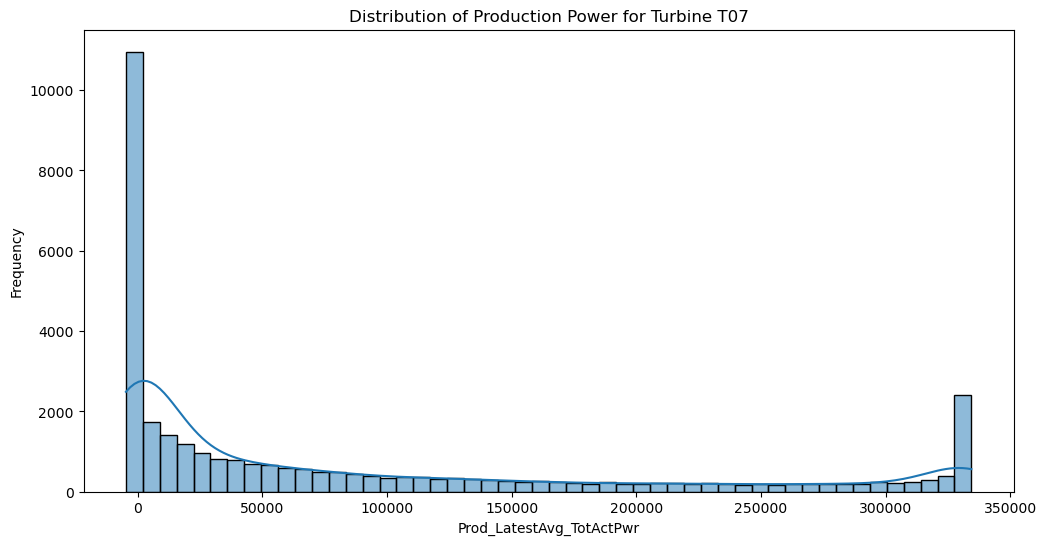

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


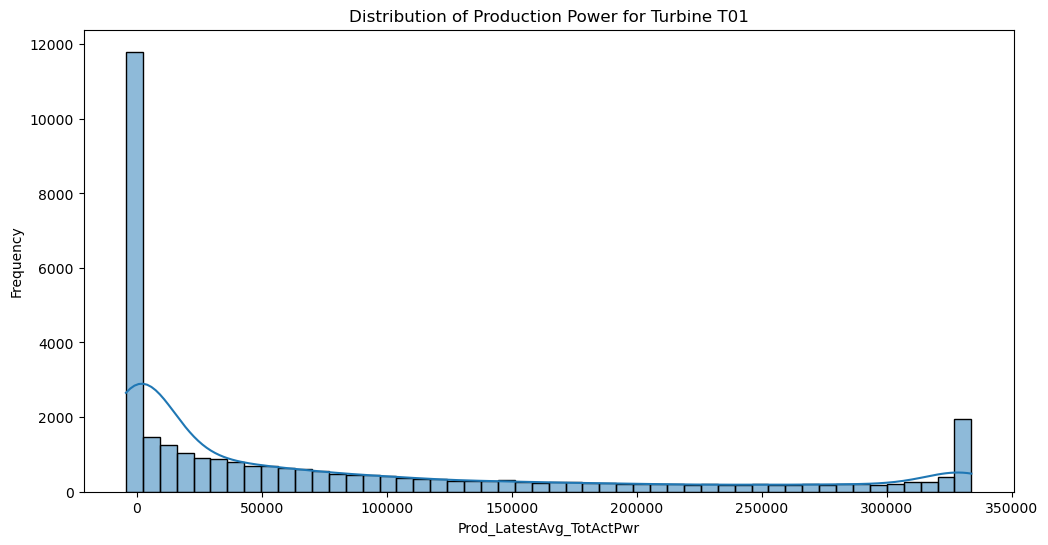

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


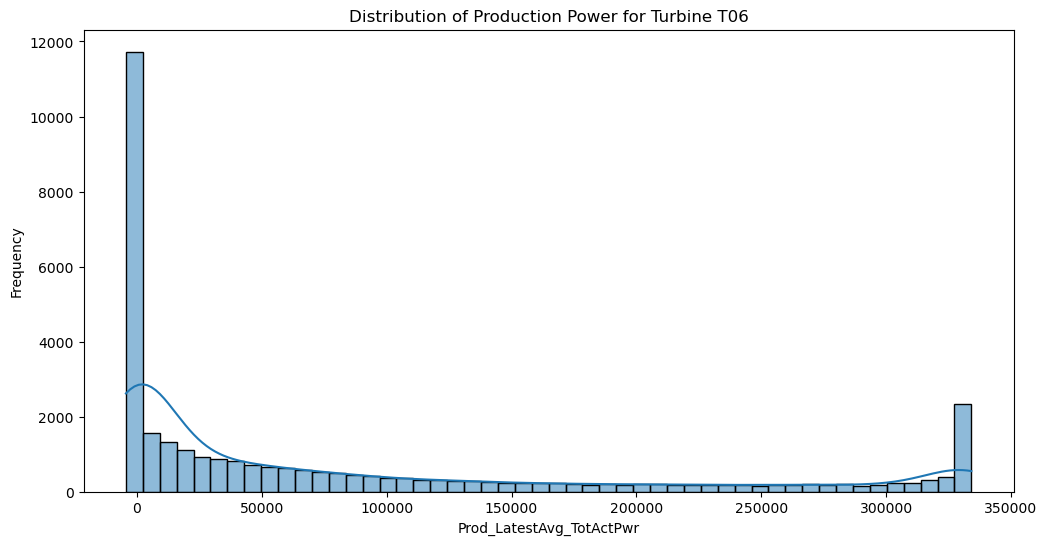

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


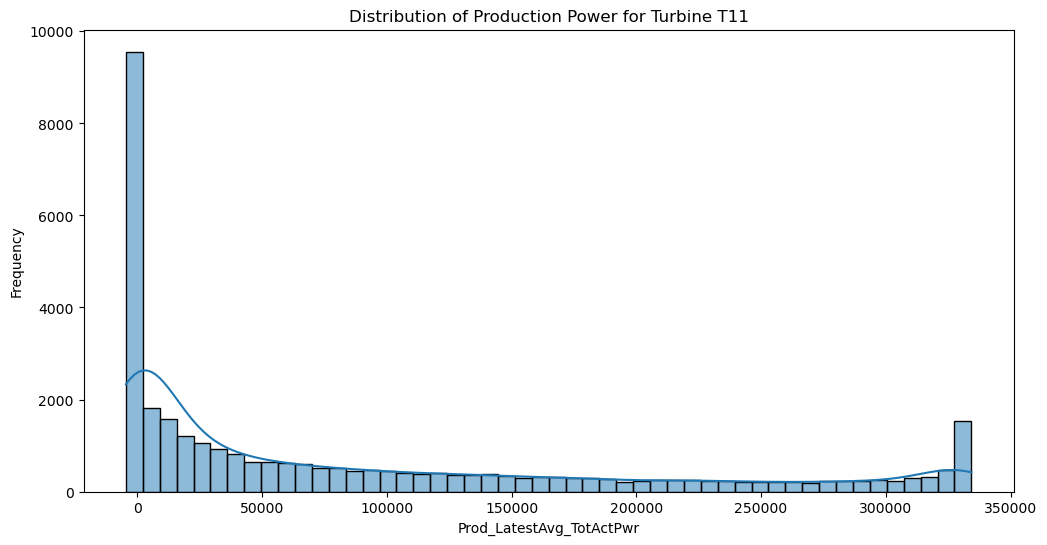

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of Prod_LatestAvg_TotActPwr for each turbine
for turbine_id in turbine_ids:
    plt.figure(figsize=(12, 6))
    sns.histplot(combined_data[turbine_id]['Prod_LatestAvg_TotActPwr'], bins=50, kde=True)
    plt.xlabel('Prod_LatestAvg_TotActPwr')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Production Power for Turbine {turbine_id}')
    plt.show()


Step 2: Adjust Parameters and Re-evaluate

Let's adjust the parameters based on the distribution and re-evaluate the outages:

In [ ]:
def identify_outages(data, window_size=30, power_threshold=500):
    for turbine in data.keys():
        df = data[turbine]
        
        # Identify outage points
        df['is_outage'] = (df['Prod_LatestAvg_TotActPwr'] < power_threshold) & \
                          (df['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True))

        # Fill NaN values in 'is_outage' with False
        df['is_outage'].fillna(False, inplace=True)

        # Remove short outages by considering consecutive points
        df['is_outage'] = df['is_outage'] & (df['is_outage'].rolling(window=3, min_periods=1).sum() >= 2)
        
        # Create RUL labels
        df['RUL'] = np.nan
        last_outage_index = None
        for i in range(len(df) - 1, -1, -1):
            if df['is_outage'].iloc[i]:
                last_outage_index = i
            if last_outage_index is not None:
                df['RUL'].iloc[i] = last_outage_index - i

        # Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
        df['RUL'].fillna(len(df), inplace=True)
        
        data[turbine] = df  # Update the data dictionary with the new columns

# Identify outages and create RUL labels for the combined data with adjusted parameters
identify_outages(combined_data)

# Plot and compare RUL for all turbines
plt.figure(figsize=(12, 6))
for turbine_id in turbine_ids:
    plt.plot(combined_data[turbine_id]['Timestamp'], combined_data[turbine_id]['RUL'], label=f'Turbine {turbine_id}')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('RUL Comparison for All Turbines')
plt.legend()
plt.show()

# Print outage points for all turbines with adjusted parameters
for turbine_id in turbine_ids:
    print(f"Outages for Turbine {turbine_id}:")
    print(combined_data[turbine_id][combined_data[turbine_id]['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']])
    print()


In [ ]:
Explanation
Distribution Analysis: Helps to understand where to set the power_threshold.
Parameter Adjustment: Adjusts the window_size and power_threshold to better capture outages.
By analyzing the distribution and adjusting parameters, you can refine the outage detection. If further adjustments are needed, you can iteratively tweak the parameters until the results align with expected behavior. Let me know if you need more guidance or specific adjustments!

In [ ]:
Final Check on Parameters
Review Distribution: Ensure the chosen threshold is appropriate for each turbine.
Consider Turbine-Specific Thresholds: If necessary, set different thresholds for each turbine based on their production power characteristics.
Proceed if Parameters Seem Reasonable: If the current parameters seem reasonable after review, proceed with the analysis.
Step 1: Review Distribution

Let's review the distribution plots once more to ensure our threshold is suitable:

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


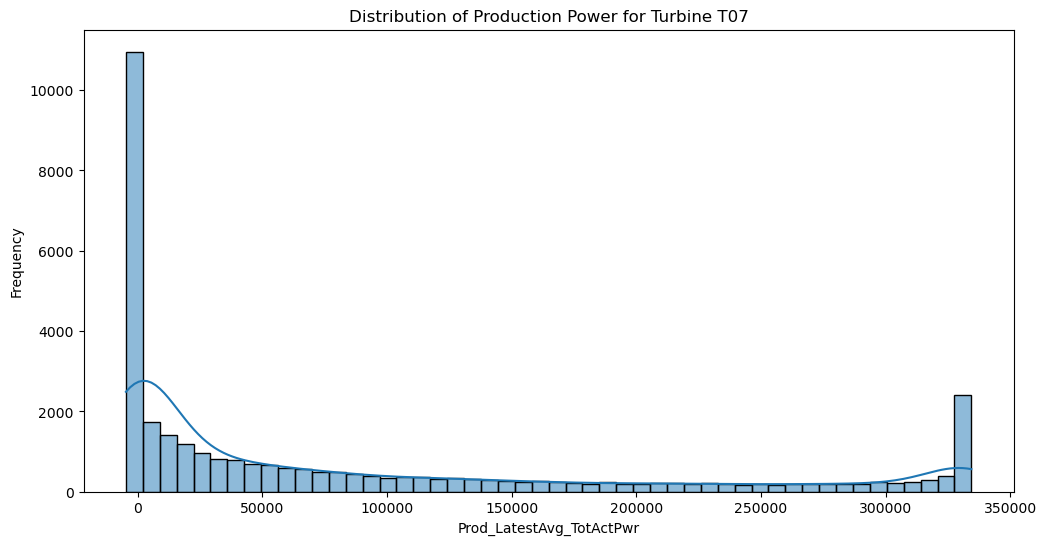

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


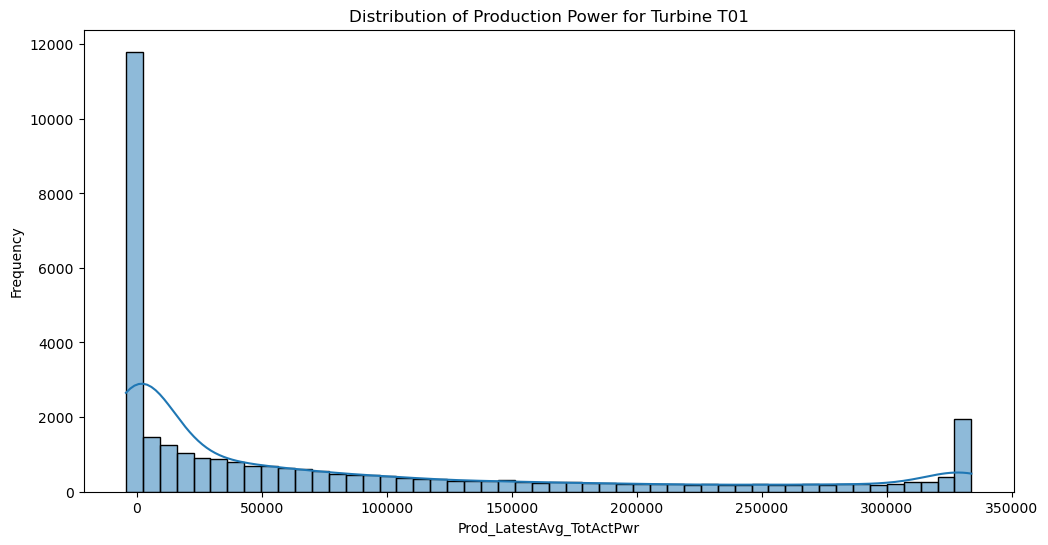

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


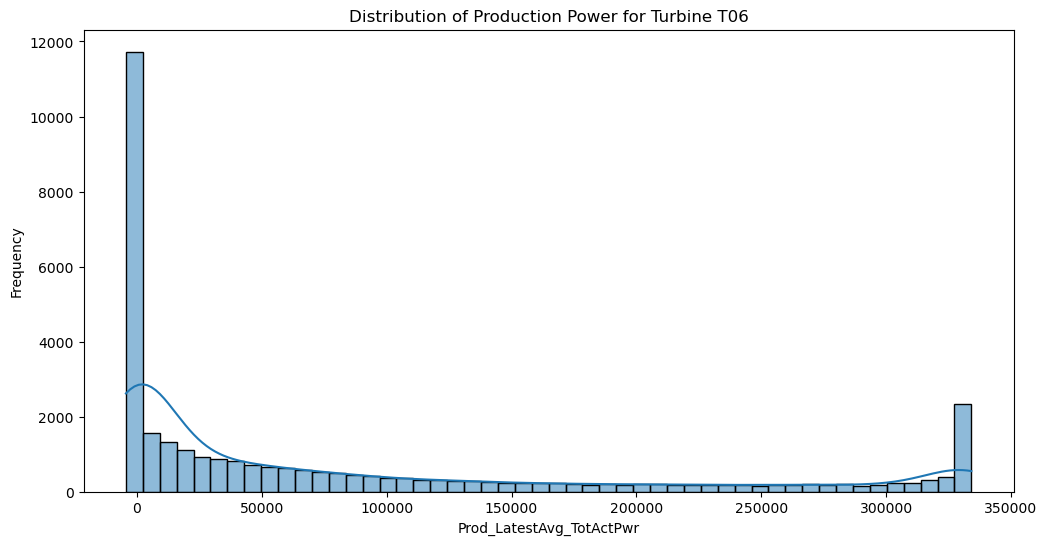

/Users/arunpasricha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


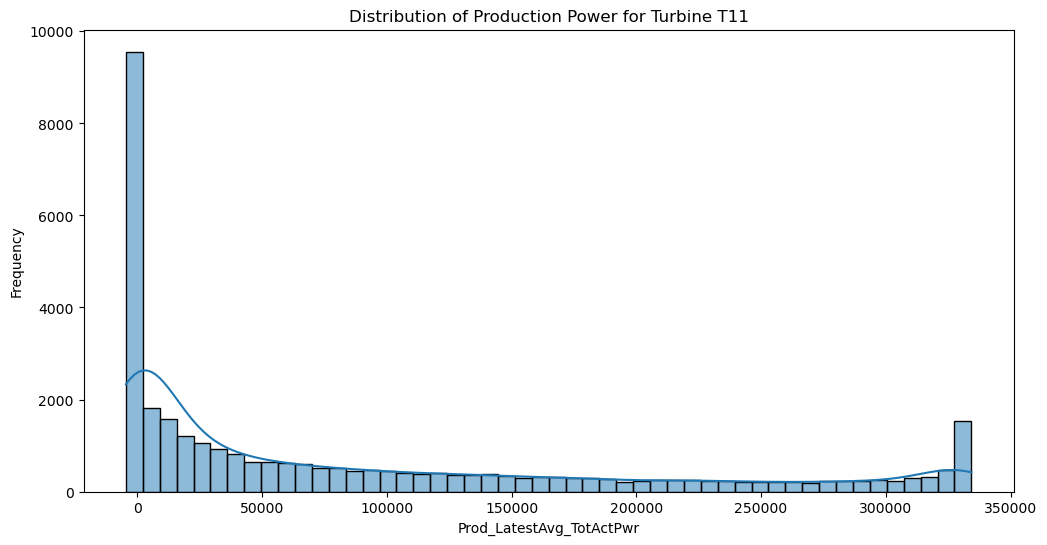

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of Prod_LatestAvg_TotActPwr for each turbine
for turbine_id in turbine_ids:
    plt.figure(figsize=(12, 6))
    sns.histplot(combined_data[turbine_id]['Prod_LatestAvg_TotActPwr'], bins=50, kde=True)
    plt.xlabel('Prod_LatestAvg_TotActPwr')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Production Power for Turbine {turbine_id}')
    plt.show()


Step 2: Consider Turbine-Specific Thresholds

If necessary, adjust the threshold based on the distribution for each turbine. Here’s an example of how you might do that:

In [ ]:
def identify_outages(data, window_size=30, power_thresholds=None):
    if power_thresholds is None:
        power_thresholds = {turbine: 500 for turbine in data.keys()}
        
    for turbine in data.keys():
        df = data[turbine]
        power_threshold = power_thresholds.get(turbine, 500)
        
        # Identify outage points
        df['is_outage'] = (df['Prod_LatestAvg_TotActPwr'] < power_threshold) & \
                          (df['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True))

        # Fill NaN values in 'is_outage' with False
        df['is_outage'].fillna(False, inplace=True)

        # Remove short outages by considering consecutive points
        df['is_outage'] = df['is_outage'] & (df['is_outage'].rolling(window=3, min_periods=1).sum() >= 2)
        
        # Create RUL labels
        df['RUL'] = np.nan
        last_outage_index = None
        for i in range(len(df) - 1, -1, -1):
            if df['is_outage'].iloc[i]:
                last_outage_index = i
            if last_outage_index is not None:
                df['RUL'].iloc[i] = last_outage_index - i

        # Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
        df['RUL'].fillna(len(df), inplace=True)
        
        data[turbine] = df  # Update the data dictionary with the new columns

# Example of setting different thresholds
power_thresholds = {
    'T06': 1000,
    'T07': 1000,
    'T01': 500,
    'T11': 500
}

# Identify outages and create RUL labels for the combined data with turbine-specific thresholds
identify_outages(combined_data, window_size=30, power_thresholds=power_thresholds)


Step 3: Re-evaluate Outages

Re-run the outage detection and review the results. If still no outages are detected for Turbine T11, it may indicate that there genuinely were no significant outages in the data provided for that turbine.

Proceeding
If the final check and adjustments seem reasonable, we can proceed with the analysis:

Identify Patterns: Look for patterns in the RUL data to predict maintenance needs.
Optimization: Develop a maintenance scheduling algorithm.
Let’s go ahead with plotting and comparing RUL for all turbines:

python


In [ ]:
# Plot and compare RUL for all turbines
plt.figure(figsize=(12, 6))
for turbine_id in turbine_ids:
    plt.plot(combined_data[turbine_id]['Timestamp'], combined_data[turbine_id]['RUL'], label=f'Turbine {turbine_id}')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('RUL Comparison for All Turbines')
plt.legend()
plt.show()

# Print outage points for all turbines with adjusted parameters
for turbine_id in turbine_ids:
    print(f"Outages for Turbine {turbine_id}:")
    print(combined_data[turbine_id][combined_data[turbine_id]['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']])
    print()


In [ ]:
# Plot and compare RUL for all turbines
plt.figure(figsize=(12, 6))
for turbine_id in turbine_ids:
    plt.plot(combined_data[turbine_id]['Timestamp'], combined_data[turbine_id]['RUL'], label=f'Turbine {turbine_id}')
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('RUL Comparison for All Turbines')
plt.legend()
plt.show()

# Print outage points for all turbines with adjusted parameters
for turbine_id in turbine_ids:
    print(f"Outages for Turbine {turbine_id}:")
    print(combined_data[turbine_id][combined_data[turbine_id]['is_outage'] == True][['Timestamp', 'Prod_LatestAvg_TotActPwr', 'is_outage', 'RUL']])
    print()


Great! Now that we have identified the outage points and created RUL labels for each turbine, let's proceed with the following steps:

Predict Maintenance Needs: Train a predictive model to estimate the Remaining Useful Life (RUL) of each part.
Optimize Maintenance Scheduling: Develop a strategy to optimize maintenance scheduling to minimize turbine downtime.
Step 1: Predict Maintenance Needs
Feature Engineering

Let's start by creating features from the data that will be useful for predicting RUL. These features can include rolling means, standard deviations, and lagged values of important columns.

In [ ]:
import numpy as np

def add_features(df):
    # Add rolling statistics
    df['Gen_RPM_Avg_RollingMean'] = df['Gen_RPM_Avg'].rolling(window=10).mean()
    df['Gen_RPM_Avg_RollingStd'] = df['Gen_RPM_Avg'].rolling(window=10).std()
    df['Gen_Bear_Temp_Avg_RollingMean'] = df['Gen_Bear_Temp_Avg'].rolling(window=10).mean()
    df['Gen_Bear_Temp_Avg_RollingStd'] = df['Gen_Bear_Temp_Avg'].rolling(window=10).std()
    
    # Add lagged values
    df['Gen_RPM_Avg_Lag1'] = df['Gen_RPM_Avg'].shift(1)
    df['Gen_RPM_Avg_Lag2'] = df['Gen_RPM_Avg'].shift(2)
    df['Gen_Bear_Temp_Avg_Lag1'] = df['Gen_Bear_Temp_Avg'].shift(1)
    df['Gen_Bear_Temp_Avg_Lag2'] = df['Gen_Bear_Temp_Avg'].shift(2)
    
    # Drop rows with NaN values created by rolling and shifting
    df.dropna(inplace=True)
    return df

# Apply feature engineering to each turbine's DataFrame
for turbine_id in turbine_ids:
    combined_data[turbine_id] = add_features(combined_data[turbine_id])

# Display the first few rows of the DataFrame for one turbine to verify
print(combined_data['T01'].head())


Model Training

Next, let's train a predictive model for RUL using the engineered features. We'll use a Random Forest Regressor as an example.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Example feature and target for generator RUL prediction
features = [
    'Gen_RPM_Avg', 'Gen_RPM_Avg_RollingMean', 'Gen_RPM_Avg_RollingStd', 
    'Gen_RPM_Avg_Lag1', 'Gen_RPM_Avg_Lag2',
    'Gen_Bear_Temp_Avg', 'Gen_Bear_Temp_Avg_RollingMean', 
    'Gen_Bear_Temp_Avg_RollingStd', 'Gen_Bear_Temp_Avg_Lag1', 'Gen_Bear_Temp_Avg_Lag2'
]

# Placeholder to store models for each turbine
models = {}

for turbine_id in turbine_ids:
    df = combined_data[turbine_id]
    
    # Split the data into training and testing sets
    X = df[features]
    y = df['RUL']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models[turbine_id] = model
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Turbine {turbine_id} - Mean Squared Error: {mse}")

# Example of accessing a model for a specific turbine
# model_T01 = models['T01']


Step 2: Optimize Maintenance Scheduling
To optimize maintenance scheduling, we need to:

Predict RUL for All Major Parts: Use the trained models to predict the RUL for each part.
Determine Optimal Maintenance Time: Develop a strategy to minimize turbine downtime by clubbing maintenance for multiple parts.
Here's an example approach to suggest maintenance scheduling:

In [ ]:
import pandas as pd

def predict_rul_for_all_parts(turbine_data, models, features):
    predictions = {}
    for turbine_id, model in models.items():
        df = turbine_data[turbine_id]
        X = df[features]
        predictions[turbine_id] = model.predict(X)
    return predictions

# Predict RUL for all turbines
rul_predictions = predict_rul_for_all_parts(combined_data, models, features)

# Example function to suggest maintenance scheduling
def suggest_maintenance_schedule(rul_predictions, threshold=200):
    maintenance_schedule = []
    for turbine_id, preds in rul_predictions.items():
        df = combined_data[turbine_id]
        df['Predicted_RUL'] = preds
        maintenance_needed = df[df['Predicted_RUL'] <= threshold]
        if not maintenance_needed.empty:
            maintenance_schedule.append((turbine_id, maintenance_needed['Timestamp'].iloc[0]))
    return maintenance_schedule

# Suggest maintenance schedule
maintenance_schedule = suggest_maintenance_schedule(rul_predictions)
print("Maintenance Schedule:")
for turbine_id, timestamp in maintenance_schedule:
    print(f"Turbine {turbine_id} needs maintenance at {timestamp}")


In [ ]:
Explanation
Feature Engineering: Adding rolling means, standard deviations, and lagged values to create features.
Model Training: Using a Random Forest Regressor to train a model to predict RUL.
Predict RUL: Predicting RUL for each turbine and part.
Maintenance Scheduling: Suggesting optimal maintenance times to minimize downtime by considering predicted RUL.
You can adjust the parameters, features, and models as needed to refine the predictions and maintenance strategy. Let me know if you need further adjustments or specific enhancements!

To extend the RUL predictions and maintenance scheduling for the next 5 years, we'll need to simulate future data. This involves:

Generating Future Timestamps: Creating a time series for the next 5 years.
Predicting Future Values: Using the trained models to predict future values of the relevant features.
Using Predicted Features: Applying the trained models to these predicted values to estimate RUL and suggest maintenance schedules.
Step 1: Generate Future Timestamps
Let's create a time series for the next 5 years.

In [ ]:
import pandas as pd

# Generate future timestamps
future_timestamps = pd.date_range(start='2018-01-01', end='2023-12-31', freq='10T')
print(future_timestamps[:5])  # Display the first few timestamps


Step 2: Predict Future Values
We need to predict future values for the features we used in our model. We'll assume some continuity in the trends of these features.

In [ ]:
def simulate_future_values(df, future_timestamps, features):
    last_values = df.iloc[-1][features]
    future_values = []

    for _ in range(len(future_timestamps)):
        next_values = last_values + np.random.normal(0, 0.01, len(features))  # Small random walk for simulation
        future_values.append(next_values)
        last_values = next_values
    
    future_df = pd.DataFrame(future_values, columns=features, index=future_timestamps)
    return future_df

# Simulate future values for each turbine
future_data = {}

for turbine_id in turbine_ids:
    future_df = simulate_future_values(combined_data[turbine_id], future_timestamps, features)
    future_data[turbine_id] = future_df

# Display the first few rows of the simulated future data for one turbine to verify
print(future_data['T01'].head())


Continuing with the Next Steps
Step 3: Predict RUL for Future Data

Using the trained models, predict the RUL for the future data.

In [61]:
def predict_future_rul(future_data, models, features):
    future_predictions = {}
    for turbine_id, model in models.items():
        df = future_data[turbine_id]
        X = df[features]
        future_predictions[turbine_id] = model.predict(X)
    return future_predictions

# Predict future RUL for all turbines
future_rul_predictions = predict_future_rul(future_data, models, features)


Step 4: Suggest Maintenance Schedule

Suggest optimal maintenance times based on the predicted future RUL.



In [ ]:
def suggest_future_maintenance_schedule(future_rul_predictions, threshold=200):
    future_maintenance_schedule = []
    for turbine_id, preds in future_rul_predictions.items():
        df = future_data[turbine_id]
        df['Predicted_RUL'] = preds
        maintenance_needed = df[df['Predicted_RUL'] <= threshold]
        if not maintenance_needed.empty:
            future_maintenance_schedule.append((turbine_id, maintenance_needed.index[0]))
    return future_maintenance_schedule

# Suggest future maintenance schedule
future_maintenance_schedule = suggest_future_maintenance_schedule(future_rul_predictions)
print("Future Maintenance Schedule:")
for turbine_id, timestamp in future_maintenance_schedule:
    print("1")
    print(f"Turbine {turbine_id} needs maintenance at {timestamp}")


Step-by-Step Debugging and Adjustment
Inspect Future RUL Predictions: Check the predicted RUL values to see if they are decreasing appropriately.
Adjust Threshold: Adjust the threshold if necessary to capture maintenance needs within the 5-year period.

Step 1: Inspect Future RUL Predictions

In [ ]:
# Display the first few rows of future RUL predictions for each turbine to verify
for turbine_id in turbine_ids:
    print(f"Future RUL Predictions for Turbine {turbine_id}:")
    print(future_data[turbine_id][['Predicted_RUL']].head())


Step 2: Adjust Threshold
If the RUL predictions are high and do not fall below the threshold, you may need to lower the threshold. Alternatively, you can adjust the simulation parameters to ensure the RUL decreases more rapidly.

In [65]:
def suggest_future_maintenance_schedule(future_rul_predictions, threshold=500):  # Adjusted threshold
    future_maintenance_schedule = []
    for turbine_id, preds in future_rul_predictions.items():
        df = future_data[turbine_id]
        df['Predicted_RUL'] = preds
        maintenance_needed = df[df['Predicted_RUL'] <= threshold]
        if not maintenance_needed.empty:
            future_maintenance_schedule.append((turbine_id, maintenance_needed.index[0]))
    return future_maintenance_schedule

# Suggest future maintenance schedule with adjusted threshold
future_maintenance_schedule = suggest_future_maintenance_schedule(future_rul_predictions)
print("Future Maintenance Schedule:")
for turbine_id, timestamp in future_maintenance_schedule:
    print(f"Turbine {turbine_id} needs maintenance at {timestamp}")


Future Maintenance Schedule:


In [ ]:
# Step 1: Generate Future Timestamps
future_timestamps = pd.date_range(start='2018-01-01', end='2023-12-31', freq='10T')

# Step 2: Simulate Future Values
def simulate_future_values(df, future_timestamps, features):
    last_values = df.iloc[-1][features]
    future_values = []

    for _ in range(len(future_timestamps)):
        next_values = last_values + np.random.normal(0, 0.01, len(features))  # Small random walk for simulation
        future_values.append(next_values)
        last_values = next_values
    
    future_df = pd.DataFrame(future_values, columns=features, index=future_timestamps)
    return future_df

# Simulate future values for each turbine
future_data = {}

for turbine_id in turbine_ids:
    future_df = simulate_future_values(combined_data[turbine_id], future_timestamps, features)
    future_data[turbine_id] = future_df

# Step 3: Predict Future RUL
def predict_future_rul(future_data, models, features):
    future_predictions = {}
    for turbine_id, model in models.items():
        df = future_data[turbine_id]
        X = df[features]
        future_predictions[turbine_id] = model.predict(X)
    return future_predictions

# Predict future RUL for all turbines
future_rul_predictions = predict_future_rul(future_data, models, features)

# Step 4: Inspect Future RUL Predictions
for turbine_id in turbine_ids:
    print(f"Future RUL Predictions for Turbine {turbine_id}:")
    print(future_data[turbine_id].head())

# Step 5: Suggest Maintenance Schedule
def suggest_future_maintenance_schedule(future_rul_predictions, threshold=500):  # Adjusted threshold
    future_maintenance_schedule = []
    for turbine_id, preds in future_rul_predictions.items():
        df = future_data[turbine_id]
        df['Predicted_RUL'] = preds
        maintenance_needed = df[df['Predicted_RUL'] <= threshold]
        if not maintenance_needed.empty:
            future_maintenance_schedule.append((turbine_id, maintenance_needed.index[0]))
    return future_maintenance_schedule

# Suggest future maintenance schedule with adjusted threshold
future_maintenance_schedule = suggest_future_maintenance_schedule(future_rul_predictions)
print("Future Maintenance Schedule:")
for turbine_id, timestamp in future_maintenance_schedule:
    print(f"Turbine {turbine_id} needs maintenance at {timestamp}")

    

In [ ]:
# Display the first few rows of the simulated future data for one turbine to verify
for turbine_id in turbine_ids:
    print(f"Simulated future data for Turbine {turbine_id}:")
    print(future_data[turbine_id].head())


In [ ]:
# Display the first few rows of future RUL predictions for each turbine to verify
for turbine_id in turbine_ids:
    future_data[turbine_id]['Predicted_RUL'] = future_rul_predictions[turbine_id]
    print(f"Future RUL Predictions for Turbine {turbine_id}:")
    print(future_data[turbine_id][['Predicted_RUL']].head())


In [ ]:
import numpy as np

def simulate_future_values(df, future_timestamps, features):
    last_values = df.iloc[-1][features]
    future_values = []

    for _ in range(len(future_timestamps)):
        next_values = last_values + np.random.normal(0, 0.1, len(features))  # Increase the magnitude of changes
        future_values.append(next_values)
        last_values = next_values
    
    future_df = pd.DataFrame(future_values, columns=features, index=future_timestamps)
    return future_df

# Simulate future values for each turbine
future_data = {}

for turbine_id in turbine_ids:
    future_df = simulate_future_values(combined_data[turbine_id], future_timestamps, features)
    future_data[turbine_id] = future_df

# Predict future RUL for all turbines
future_rul_predictions = predict_future_rul(future_data, models, features)

# Inspect future RUL predictions
for turbine_id in turbine_ids:
    future_data[turbine_id]['Predicted_RUL'] = future_rul_predictions[turbine_id]
    print(f"Future RUL Predictions for Turbine {turbine_id}:")
    print(future_data[turbine_id][['Predicted_RUL']].head())

# Suggest future maintenance schedule with adjusted threshold
future_maintenance_schedule = suggest_future_maintenance_schedule(future_rul_predictions)
print("Future Maintenance Schedule:")
for turbine_id, timestamp in future_maintenance_schedule:
    print(f"Turbine {turbine_id} needs maintenance at {timestamp}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load the data from the Excel files
file_path_2016 = 'Signals_2016.xlsx'
file_path_2017 = 'Signals_2017.xlsx'

data_2016 = pd.read_excel(file_path_2016, sheet_name='Signals_2016')
data_2017 = pd.read_excel(file_path_2017, sheet_name='Signals_2017')

# Convert 'Timestamp' to datetime
data_2016['Timestamp'] = pd.to_datetime(data_2016['Timestamp'])
data_2017['Timestamp'] = pd.to_datetime(data_2017['Timestamp'])

# Extract unique turbine IDs
turbine_ids = ['T06', 'T07', 'T01', 'T11']

# Combine data for each turbine
combined_data = {}
for turbine_id in turbine_ids:
    df_2016 = data_2016[data_2016['Turbine_ID'] == turbine_id].copy()
    df_2017 = data_2017[data_2017['Turbine_ID'] == turbine_id].copy()
    combined_df = pd.concat([df_2016, df_2017], ignore_index=True)
    combined_data[turbine_id] = combined_df

# Add feature engineering functions
def add_features(df):
    df['Gen_RPM_Avg_RollingMean'] = df['Gen_RPM_Avg'].rolling(window=10).mean()
    df['Gen_RPM_Avg_RollingStd'] = df['Gen_RPM_Avg'].rolling(window=10).std()
    df['Gen_Bear_Temp_Avg_RollingMean'] = df['Gen_Bear_Temp_Avg'].rolling(window=10).mean()
    df['Gen_Bear_Temp_Avg_RollingStd'] = df['Gen_Bear_Temp_Avg'].rolling(window=10).std()
    df['Gen_RPM_Avg_Lag1'] = df['Gen_RPM_Avg'].shift(1)
    df['Gen_RPM_Avg_Lag2'] = df['Gen_RPM_Avg'].shift(2)
    df['Gen_Bear_Temp_Avg_Lag1'] = df['Gen_Bear_Temp_Avg'].shift(1)
    df['Gen_Bear_Temp_Avg_Lag2'] = df['Gen_Bear_Temp_Avg'].shift(2)
    df.dropna(inplace=True)
    return df

# Apply feature engineering
for turbine_id in turbine_ids:
    combined_data[turbine_id] = add_features(combined_data[turbine_id])

# Identify outages and create RUL labels
def identify_outages(data, window_size=30, power_threshold=2000):
    for turbine in data.keys():
        df = data[turbine]
        
        # Identify outage points
        df['is_outage'] = (df['Prod_LatestAvg_TotActPwr'] < power_threshold) & \
                          (df['Prod_LatestAvg_TotActPwr'].rolling(window=window_size, center=True).apply(lambda x: x.min() == x[window_size // 2], raw=True))

        # Fill NaN values in 'is_outage' with False
        df['is_outage'].fillna(False, inplace=True)

        # Remove short outages by considering consecutive points
        df['is_outage'] = df['is_outage'] & (df['is_outage'].rolling(window=3, min_periods=1).sum() >= 2)
        
        # Create RUL labels
        df['RUL'] = np.nan
        last_outage_index = None
        for i in range(len(df) - 1, -1, -1):
            if df['is_outage'].iloc[i]:
                last_outage_index = i
            if last_outage_index is not None:
                df['RUL'].iloc[i] = last_outage_index - i

        # Fill remaining NaN values in 'RUL' with a large number (assuming they are far from an outage)
        df['RUL'].fillna(len(df), inplace=True)
        
        data[turbine] = df  # Update the data dictionary with the new columns

# Identify outages and create RUL labels for the combined data
identify_outages(combined_data)

# Example features and target
features = [
    'Gen_RPM_Avg', 'Gen_RPM_Avg_RollingMean', 'Gen_RPM_Avg_RollingStd', 
    'Gen_RPM_Avg_Lag1', 'Gen_RPM_Avg_Lag2',
    'Gen_Bear_Temp_Avg', 'Gen_Bear_Temp_Avg_RollingMean', 
    'Gen_Bear_Temp_Avg_RollingStd', 'Gen_Bear_Temp_Avg_Lag1', 'Gen_Bear_Temp_Avg_Lag2'
]

# Train models
models = {}
for turbine_id in turbine_ids:
    df = combined_data[turbine_id]
    X = df[features]
    y = df['RUL']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    models[turbine_id] = model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Turbine {turbine_id} - Mean Squared Error: {mse}")

# Generate future timestamps
future_timestamps = pd.date_range(start='2018-01-01', end='2025-12-31', freq='10T')

# Simulate future values with larger changes
def simulate_future_values(df, future_timestamps, features):
    last_values = df.iloc[-1][features]
    future_values = []

    for _ in range(len(future_timestamps)):
        next_values = last_values + np.random.normal(0, 1, len(features))  # Significantly larger changes
        future_values.append(next_values)
        last_values = next_values
    
    future_df = pd.DataFrame(future_values, columns=features, index=future_timestamps)
    return future_df

# Simulate future values for each turbine
future_data = {}
for turbine_id in turbine_ids:
    future_df = simulate_future_values(combined_data[turbine_id], future_timestamps, features)
    future_data[turbine_id] = future_df

# Predict future RUL for all turbines
def predict_future_rul(future_data, models, features):
    future_predictions = {}
    for turbine_id, model in models.items():
        df = future_data[turbine_id]
        X = df[features]
        future_predictions[turbine_id] = model.predict(X)
    return future_predictions

# Predict future RUL for all turbines
future_rul_predictions = predict_future_rul(future_data, models, features)

# Inspect future RUL predictions
for turbine_id in turbine_ids:
    future_data[turbine_id]['Predicted_RUL'] = future_rul_predictions[turbine_id]
    print(f"Future RUL Predictions for Turbine {turbine_id}:")
    print(future_data[turbine_id][['Predicted_RUL']].head())

# Suggest future maintenance schedule with adjusted threshold
def suggest_future_maintenance_schedule(future_rul_predictions, threshold=2000):
    future_maintenance_schedule = []
    for turbine_id, preds in future_rul_predictions.items():
        df = future_data[turbine_id]
        df['Predicted_RUL'] = preds
        maintenance_needed = df[df['Predicted_RUL'] <= threshold]
        if not maintenance_needed.empty:
            future_maintenance_schedule.append((turbine_id, maintenance_needed.index[0]))
    return future_maintenance_schedule

# Suggest future maintenance schedule
future_maintenance_schedule = suggest_future_maintenance_schedule(future_rul_predictions)
print("Future Maintenance Schedule:")
for turbine_id, timestamp in future_maintenance_schedule:
    print(f"Turbine {turbine_id} needs maintenance at {timestamp}")


In [ ]:
# Inspect future RUL predictions
for turbine_id in turbine_ids:
    future_data[turbine_id]['Predicted_RUL'] = future_rul_predictions[turbine_id]
    print(f"Future RUL Predictions for Turbine {turbine_id}:")
    print(future_data[turbine_id][['Predicted_RUL']])